Assignment #2 neural network
mojtaba aprouz - 40030594

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
#@title dataset
!unzip //content/drive/MyDrive/Colab_Notebooks/Butterfly_images.zip

Archive:  //content/drive/MyDrive/Colab_Notebooks/Butterfly_images.zip
  inflating: Butterfly_images/family.txt  
  inflating: Butterfly_images/genus.txt  
  inflating: Butterfly_images/hierarchy.mat  
 extracting: Butterfly_images/images_small.zip  
  inflating: Butterfly_images/species.txt  
  inflating: Butterfly_images/subfamily.txt  


In [ ]:
#@title dataset
!unzip /content/Butterfly_images/images_small.zip

In [14]:
import splitfolders
splitfolders.ratio("/content/images_small/images_small/images_small",output="ds",seed=1337,ratio=(0.8,0.1,0.1), group_prefix=None, move=False)

Copying files: 5652 files [00:00, 5814.52 files/s]


In [40]:
import os
import numpy as np
import cv2
from tensorflow import keras
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.mobilenet import MobileNet
from  matplotlib import pyplot as plt


In [41]:
def loss_plot(network):
    dict = network.history
    loss_values = dict['loss']
    val_loss_values = dict['val_loss']
    epochs = range(1, len(loss_values) + 1)
    plt.plot(epochs, loss_values, 'bo', label='Training')
    plt.plot(epochs, val_loss_values,'r', label='Validation')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [42]:
def acc_plot(network):
    plt.clf()
    dict = network.history
    acc_values = dict['accuracy']
    val_acc_values = dict['val_accuracy']
    epochs = range(1, len(acc_values) + 1)
    plt.plot(epochs, acc_values, 'bo', label='Training')
    plt.plot(epochs, val_acc_values, 'r', label='Validation')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('accuracy')
    plt.legend()
    plt.show()

In [43]:
base_dir, _ = os.path.splitext('/content/ds')

train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')
val_dir = os.path.join(base_dir, 'val')
batch_size=20
image_size = 224


In [44]:
tr_datagen= ImageDataGenerator(rescale=1./255,
                               rotation_range=40,
                               width_shift_range=0.2,
                               height_shift_range=0.2,
                               shear_range=0.2,
                               zoom_range=0.2,
                               horizontal_flip=True,
                               fill_mode='nearest'
                               )
te_datagen= ImageDataGenerator(rescale=1./255)
vl_datagen= ImageDataGenerator(rescale=1./255)

train_gen=tr_datagen.flow_from_directory(
    train_dir,
    target_size=(image_size,image_size),
    batch_size= batch_size,
    class_mode='categorical'
)
val_gen=vl_datagen.flow_from_directory(
    val_dir,
    target_size=(image_size,image_size),
    batch_size= batch_size,
    class_mode='categorical'
)
test_gen=te_datagen.flow_from_directory(
    test_dir,
    target_size=(image_size,image_size),
    batch_size= batch_size,
    class_mode='categorical'
)

Found 4500 images belonging to 50 classes.
Found 540 images belonging to 50 classes.
Found 612 images belonging to 50 classes.


In [45]:
conv_base = MobileNet(weights='imagenet',
include_top=False,
input_shape=(224, 224, 3))
conv_base.trainable = False


In [46]:
conv_base.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         

Freeze base net and train added dense layers

In [53]:
model=keras.models.Sequential()
model.add(conv_base)
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(1024,activation='ReLU'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(50,activation='softmax'))

In [54]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 50176)             0         
                                                                 
 dense_6 (Dense)             (None, 1024)              51381248  
                                                                 
 dropout_3 (Dropout)         (None, 1024)              0         
                                                                 
 dense_7 (Dense)             (None, 50)                51250     
                                                                 
Total params: 54,661,362
Trainable params: 51,432,498
Non-trainable params: 3,228,864
__________________________________

In [55]:
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=2e-5),loss='categorical_crossentropy',metrics=['accuracy'])

In [57]:
history = model.fit_generator(train_gen,
 epochs=10,
 steps_per_epoch=len(train_gen),
 validation_data=(val_gen))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if sys.path[0] == '':


Epoch 1/10
225/225 [==============================] - 67s 293ms/step - loss: 3.8525 - accuracy: 0.1880 - val_loss: 2.0728 - val_accuracy: 0.4481
Epoch 2/10
225/225 [==============================] - 67s 299ms/step - loss: 2.5399 - accuracy: 0.3587 - val_loss: 1.5477 - val_accuracy: 0.5259
Epoch 3/10
225/225 [==============================] - 66s 294ms/step - loss: 2.1128 - accuracy: 0.4420 - val_loss: 1.2390 - val_accuracy: 0.6111
Epoch 4/10
225/225 [==============================] - 65s 287ms/step - loss: 1.8673 - accuracy: 0.5022 - val_loss: 1.1382 - val_accuracy: 0.6667
Epoch 5/10
225/225 [==============================] - 66s 295ms/step - loss: 1.6843 - accuracy: 0.5524 - val_loss: 1.0591 - val_accuracy: 0.6778
Epoch 6/10
225/225 [==============================] - 65s 288ms/step - loss: 1.5064 - accuracy: 0.5833 - val_loss: 1.0039 - val_accuracy: 0.6889
Epoch 7/10
225/225 [==============================] - 66s 294ms/step - loss: 1.4381 - accuracy: 0.6022 - val_loss: 0.9507 - val_ac

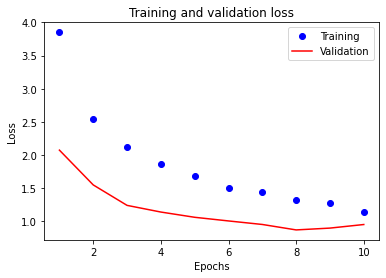

In [58]:
loss_plot(history)

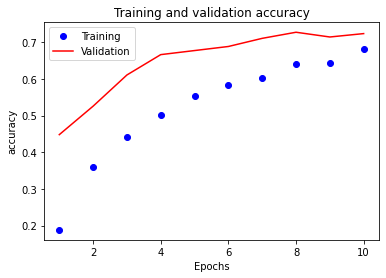

In [59]:
acc_plot(history)

In [60]:
test_out=model.evaluate(train_gen,steps=50)
print('acc:',test_out[1], 'loss:',test_out[0])

50/50 [==============================] - 15s 296ms/step - loss: 0.6115 - accuracy: 0.8100


[0.6114592552185059, 0.8100000023841858]

In [61]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 50176)             0         
                                                                 
 dense_6 (Dense)             (None, 1024)              51381248  
                                                                 
 dropout_3 (Dropout)         (None, 1024)              0         
                                                                 
 dense_7 (Dense)             (None, 50)                51250     
                                                                 
Total params: 54,661,362
Trainable params: 51,432,498
Non-trainable params: 3,228,864
__________________________________

PART **5**

Freeze layer 13

In [78]:
conv_base.trainable=True

set_trainable=False
for layer in conv_base.layers:
    if layer.name=='conv_dw_13':
        set_trainable = True
    if set_trainable :
        layer.trainable=True
    else :
        layer.trainable=False


In [80]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 50176)             0         
                                                                 
 dense_6 (Dense)             (None, 1024)              51381248  
                                                                 
 dropout_3 (Dropout)         (None, 1024)              0         
                                                                 
 dense_7 (Dense)             (None, 50)                51250     
                                                                 
Total params: 54,661,362
Trainable params: 52,494,386
Non-trainable params: 2,166,976
__________________________________

In [81]:
len(train_gen)

225

In [82]:
model.compile(optimizer=keras.optimizers.RMSprop(lr=2e-5),loss='categorical_crossentropy',metrics=['accuracy'])
history = model.fit_generator(train_gen,
 epochs=10,
 steps_per_epoch=len(train_gen),
 validation_data=(val_gen));

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/10
225/225 [==============================] - 69s 300ms/step - loss: 1.3179 - accuracy: 0.6487 - val_loss: 0.9919 - val_accuracy: 0.7259
Epoch 2/10
225/225 [==============================] - 65s 291ms/step - loss: 1.2211 - accuracy: 0.6700 - val_loss: 0.9654 - val_accuracy: 0.7296
Epoch 3/10
225/225 [==============================] - 67s 298ms/step - loss: 1.1236 - accuracy: 0.6836 - val_loss: 0.8938 - val_accuracy: 0.7352
Epoch 4/10
225/225 [==============================] - 65s 291ms/step - loss: 1.0736 - accuracy: 0.6960 - val_loss: 0.9041 - val_accuracy: 0.7444
Epoch 5/10
225/225 [==============================] - 67s 297ms/step - loss: 1.0380 - accuracy: 0.7158 - val_loss: 0.9229 - val_accuracy: 0.7444
Epoch 6/10
225/225 [==============================] - 67s 297ms/step - loss: 0.9842 - accuracy: 0.7238 - val_loss: 0.9396 - val_accuracy: 0.7630
Epoch 7/10
225/225 [==============================] - 65s 290ms/step - loss: 0.9424 - accuracy: 0.7378 - val_loss: 0.8608 - val_ac

In [83]:
test_out=model.evaluate(train_gen,steps=50)
print('acc:',test_out[1], 'loss:',test_out[0])

50/50 [==============================] - 13s 267ms/step - loss: 0.3509 - accuracy: 0.8970
acc: 0.8970000147819519 loss: 0.350898802280426


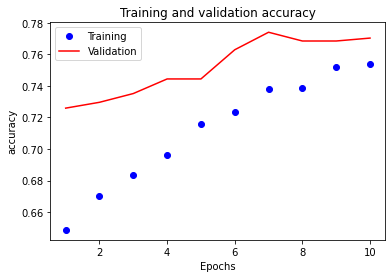

In [84]:
acc_plot(history)

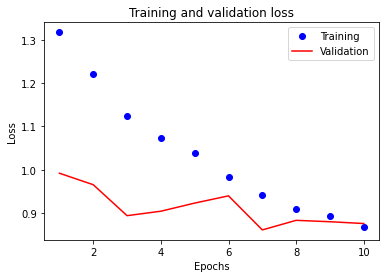

In [85]:
loss_plot(history)

PART **6**

Freeze layer 12 & 13


In [86]:
conv_base.trainable=True

set_trainable=False
for layer in conv_base.layers:
    if layer.name=='conv_dw_12':
        set_trainable = True
    if set_trainable :
        layer.trainable=True
    else :
        layer.trainable=False




In [88]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 50176)             0         
                                                                 
 dense_6 (Dense)             (None, 1024)              51381248  
                                                                 
 dropout_3 (Dropout)         (None, 1024)              0         
                                                                 
 dense_7 (Dense)             (None, 50)                51250     
                                                                 
Total params: 54,661,362
Trainable params: 53,026,354
Non-trainable params: 1,635,008
__________________________________

In [89]:
model.compile(optimizer=keras.optimizers.RMSprop(lr=2e-5),loss='categorical_crossentropy',metrics=['accuracy'])

history = model.fit_generator(train_gen,
 epochs=10,
 steps_per_epoch=len(train_gen),
 validation_data=(val_gen));

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/10
225/225 [==============================] - 69s 298ms/step - loss: 0.8876 - accuracy: 0.7507 - val_loss: 0.9071 - val_accuracy: 0.7630
Epoch 2/10
225/225 [==============================] - 66s 292ms/step - loss: 0.8111 - accuracy: 0.7749 - val_loss: 0.9068 - val_accuracy: 0.7685
Epoch 3/10
225/225 [==============================] - 67s 298ms/step - loss: 0.7876 - accuracy: 0.7818 - val_loss: 0.8864 - val_accuracy: 0.7796
Epoch 4/10
225/225 [==============================] - 66s 291ms/step - loss: 0.7830 - accuracy: 0.7771 - val_loss: 0.8772 - val_accuracy: 0.7741
Epoch 5/10
225/225 [==============================] - 67s 297ms/step - loss: 0.7283 - accuracy: 0.7884 - val_loss: 0.8658 - val_accuracy: 0.7778
Epoch 6/10
225/225 [==============================] - 66s 291ms/step - loss: 0.6891 - accuracy: 0.8080 - val_loss: 0.9887 - val_accuracy: 0.7741
Epoch 7/10
225/225 [==============================] - 67s 299ms/step - loss: 0.6666 - accuracy: 0.8084 - val_loss: 0.9289 - val_ac

In [90]:
test_out=model.evaluate(train_gen,steps=50)
print('acc:',test_out[1], 'loss:',test_out[0])

50/50 [==============================] - 14s 272ms/step - loss: 0.2364 - accuracy: 0.9150
acc: 0.9150000214576721 loss: 0.23641742765903473


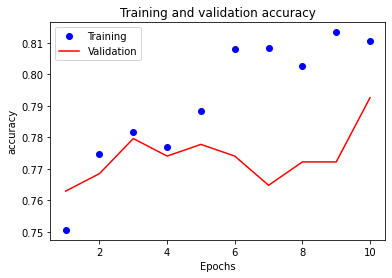

In [91]:
acc_plot(history)

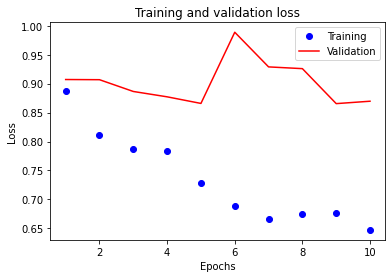

In [92]:
loss_plot(history)

در مقایسه نتایج بخش 5 و 6 میتوان دید که با آموزش دیدن وزن ها لایه های کانولوشن شاهد تغییرات در دقت هستیم اما میتوان این را نیز در نظر گرفت با تفاوت زیادی نیست.اما در کل با با تغییر وزن های بیشتر مدل بر روی دیتاست ما مطابق بیشتری خواهد داشت اما پیچیدگی و هزینه بیشتری صرف میکنیم.
یک مورد دیگر که باید اشاره کرد محدودیتی است که ما در اجرای و اموزش این شبکه داشتیم که به دلیل پارامتر های زیاد امکان اجرای اپوک های بیشتر نبود که در ان صورت قطعا به دقت بالاتری دست پیدا میکردیم